In [1]:
# ここのコードを ~パクリ~ 参考にした
# https://qiita.com/yukoba/items/7a687e44395783eb32b1

In [3]:
import numpy as np
import scipy.misc
from keras import backend as K
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [4]:
# ひらがなデータ・セットをダウンロード
!wget https://github.com/yukoba/CnnJapaneseCharacter/raw/master/src/hiragana.npz  -O hiragana.npz

--2019-04-28 01:19:49--  https://github.com/yukoba/CnnJapaneseCharacter/raw/master/src/hiragana.npz
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yukoba/CnnJapaneseCharacter/master/src/hiragana.npz [following]
--2019-04-28 01:19:50--  https://raw.githubusercontent.com/yukoba/CnnJapaneseCharacter/master/src/hiragana.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6680956 (6.4M) [application/octet-stream]
Saving to: ‘hiragana.npz’

hiragana.npz        100%[===================>]   6.37M  --.-KB/s    in 0.1s    

2019-04-28 01:19:50 (66.9 MB/s) - ‘hiragana.npz’ saved [6680956/66

# データの準備

In [5]:
nb_classes = 72
img_rows, img_cols = 32, 32

ary = np.load('hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32) / 15
X_train = np.zeros([nb_classes * 160, img_rows, img_cols], dtype=np.float32)
for i in range(nb_classes * 160):
    X_train[i] = scipy.misc.imresize(ary[i], (img_rows, img_cols), mode='F')
    # X_train[i] = ary[i]
Y_train = np.repeat(np.arange(nb_classes), 160)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


In [6]:
input_shape

(32, 32, 1)

In [0]:
# なんか漢字も入っているけど、githubのissueみたらバグっぽい
# 修正するの面倒なので一旦これで進める.
labels = list('あいうえおか平がきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよら開りるれろわん')

In [0]:
# 画像を複製する
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.20)
datagen.fit(X_train)

# モデル定義

In [11]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)
  

def lstm_model(input_shape, nb_classes):
    model = Sequential()
    model.add(Reshape((32, 32), input_shape=input_shape))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(256))
    model.add(Dense(nb_classes, kernel_initializer=weight_variable))
    model.add(Activation('softmax'))
            
    return model


def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

  
model = lstm_model(input_shape, nb_classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', auc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 32, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               591872    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 72)                18504     
_________________________________________________________________
activation_2 (Activation)    (None, 72)                0         
Total params: 741,704
Trainable params: 741,704
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# 学習

In [12]:
n_epochs = 50
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=16), samples_per_epoch=X_train.shape[0],
                    nb_epoch=n_epochs, validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., steps_per_epoch=576, epochs=50)`
  after removing the cwd from sys.path.


Epoch 1/50
576/576 [==============================] - 76s 132ms/step - loss: 3.3290 - acc: 0.1306 - auc: 0.7369 - val_loss: 2.4806 - val_acc: 0.2704 - val_auc: 0.8599
Epoch 2/50
576/576 [==============================] - 74s 129ms/step - loss: 2.4669 - acc: 0.2854 - auc: 0.8866 - val_loss: 2.0250 - val_acc: 0.3689 - val_auc: 0.9039
Epoch 3/50
576/576 [==============================] - 74s 129ms/step - loss: 2.0473 - acc: 0.3994 - auc: 0.9151 - val_loss: 1.5771 - val_acc: 0.5213 - val_auc: 0.9244
Epoch 4/50
576/576 [==============================] - 75s 131ms/step - loss: 1.6860 - acc: 0.4939 - auc: 0.9318 - val_loss: 1.3868 - val_acc: 0.5664 - val_auc: 0.9379
Epoch 5/50
576/576 [==============================] - 75s 129ms/step - loss: 1.3736 - acc: 0.5767 - auc: 0.9431 - val_loss: 1.1102 - val_acc: 0.6406 - val_auc: 0.9478
Epoch 6/50
576/576 [==============================] - 74s 129ms/step - loss: 1.1325 - acc: 0.6457 - auc: 0.9517 - val_loss: 0.8949 - val_acc: 0.7114 - val_auc: 0.955

In [0]:
!ls

hiragana.npz  IMG_1060.jpg  jpn.traineddata  sample_data


In [0]:
# モデルを保存する.
model.save_weights('./save.weights')

# 予測してみる

In [14]:
model.model.input.shape

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(1)])

In [0]:
from PIL import Image
import numpy as np

In [0]:
img = Image.open('../img/canvas_あ.png')

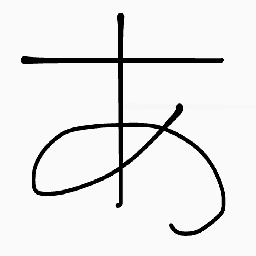

In [17]:
# chrome canvasで作成した手書き（？）画像
img.resize((256, 256))

In [0]:
img = img.convert('L').resize((32, 32))
img_np = np.array(img).reshape(1, 32, 32, 1)

In [23]:
label_id = np.argmax(model.predict(img_np))
labels[label_id]

'ざ'

（°ω°